# Goal

Get the first and last authorship for all CHW authors. Also apply my custom function for weighting authorship position. My custom weight function is defined by:
$$
    f(k,n,b,c) = 1 - c\left( \sigma(b(k-2)) - \sigma(b(k-(n-1))) \right),
$$
where 
- $k$ is the author position, 
- $n$ is the number of authors, 
- $b$ controls the steepness of the trough (I set $b = 4$), 
- $c$ is the minimum weight you want to assign to middle authors (in my case I set $c = (n-1)/n$ to give a minimum weight of 1/n), 
- and $\sigma$ is the logistic/sigmoid function.

In [1]:
import numpy as np
import pandas as pd
import string
import re
import pickle

import pybliometrics
from pybliometrics.scopus import AuthorRetrieval
import elsapy_utils as ep
import json
import requests
import plotly.express as px

# import spacy
# from spacy.lang.en import English
# from nltk.probability import FreqDist
# from nltk.corpus import stopwords
# from nltk import sent_tokenize
# from nltk.tokenize import word_tokenize
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.tag import pos_tag

# from nltk.metrics import BigramAssocMeasures
# from nltk.metrics import TrigramAssocMeasures
# from nltk.collocations import BigramCollocationFinder
# from nltk.collocations import TrigramCollocationFinder

# from sklearn.preprocessing import MultiLabelBinarizer

# spacy.prefer_gpu()

# # define the lemmatizer and the set of stopwords
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# # load English tokenizer, tagger, parser, NER and word vectors
# nlp = English()

# # create the binarizer
# mlb = MultiLabelBinarizer()

# nlp.max_length = 20000000
# nlp.add_pipe('sentencizer')

# # get the custom wordmap I've been working on
# with open('wordmap.pickle', 'rb') as file:
#     wordmap = pickle.load(file)

In [2]:
def author_position(row: list, auid: int) -> float:
    """ Find the author position in a list of authors. """
            
    # find the location of auid in the list of positions
    try:
        return row.index(auid)
    except:
        return np.nan

def trough(position: float, length: float, b = 4) -> float:
    """ This implements the custom author weight function.
        The fundamental assumption is that authors at the
        beginning and end of the author list contribute 
        more to a publication than middle authors.
        
        args:
        -----
        position - where the author is located in the authorship list
        length   - total number of authors in the authorship list
        b        - parameter for the slope of the 'trough' in the trough function
        
        returns:
        --------
        author weight according to the trough function
    """
    
    def sigmoid(x: float) -> float:
        """ The sigmoid/logistic function. """
        return 1/(1 + np.exp(-x))
    
    c = (length-1)/length
    
    try:
        return 1-c*(sigmoid(b*(position - 1)) - sigmoid(b*(position - length + 2)))
    except:
        return np.nan

def convert_eu_to_float(x: str or float or int) -> float:
    """ Convert number of the form 0,xx to 0.xx """
    
    if isinstance(x, float):
        return x
    else:
        return float(x.replace(',', '.'))
    
def count_affils(affils: list) -> int:
    """ Accepts a list of affiliations and returns the length. 
        Logic is included for where the list is empty.
    """
    
    if isinstance(affils, float):
        return 0
    else:
        return len(affils)

def publication_metrics(profiles):
    """ Generate df to hold all publication metrics for each author 
    
        args:
        -----
        profiles - dict of {auid: AuthorRetrieval object}
        
        returns:
        --------
        dict of the form
                 auid: [
                     indexed_name,
                     affiliation_current,
                     affiliation_history,
                     alias,
                     citation_count,
                     cited_by_count,
                     coauthor_count,
                     classificationgroup,
                     document_count,
                     h_index,
                     orcid,
                     publication_range,
                     subject_areas
                 ]
    """
    
    return {
        author: [
            profiles[author].indexed_name,
            profiles[author].affiliation_current,
            profiles[author].affiliation_history,
            profiles[author].alias,
            profiles[author].citation_count,
            profiles[author].cited_by_count,
            profiles[author].coauthor_count,
            profiles[author].classificationgroup,
            profiles[author].document_count,
            profiles[author].h_index,
            profiles[author].orcid,
            profiles[author].publication_range,
            profiles[author].subject_areas,
        ] for author in profiles
    }

In [3]:
df_pub = pd.read_csv('../Datasets/chw_publications.csv')
# ucal_pub = pd.read_csv('../Datasets/ucalgary_publications.csv')

# remove O'Brien to focus on CHW authors
# df_auth = df_auth[df_auth['OBRIEN'] == 0]
df_pub.rename(columns = {'CHW author': 'Auid'}, inplace = True)

# remove overlap between UCalgary and CHW publications
# ucal_pub = ucal_pub[~ucal_pub['Auid'].isin(df_pub['Auid'])]
# ucal_pub['affil'] = 'UCalgary'

# df_pub = pd.concat([df_pub, ucal_pub])

df_pub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219997 entries, 0 to 219996
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Auid                 219997 non-null  int64  
 1   eid                  219997 non-null  object 
 2   doi                  205160 non-null  object 
 3   pii                  59958 non-null   object 
 4   pubmed_id            179365 non-null  float64
 5   title                219989 non-null  object 
 6   subtype              219997 non-null  object 
 7   subtypeDescription   219913 non-null  object 
 8   creator              219890 non-null  object 
 9   afid                 213954 non-null  object 
 10  affilname            213954 non-null  object 
 11  affiliation_city     213608 non-null  object 
 12  affiliation_country  213908 non-null  object 
 13  author_count         219929 non-null  float64
 14  author_names         219929 non-null  object 
 15  author_ids       

# Get author positions

In [4]:
# reduce the number of columns
df_pos = df_pub[['Auid', 'author_ids', 'author_count', 'citedby_count', 'eid']]

# remove any missing rows
df_pos = df_pos[~df_pos.author_ids.isna()]

# get individual author ids
df_pos['auids'] = df_pos['author_ids'].str.split(';')

# convert auids to int
df_pos['auids'] = df_pos['auids'].apply(lambda x: [int(i) for i in x])

# get the chw author positions - come back to see the ones not found in their own author lists
not_found = []

for i in df_pos.index:
    try:
        df_pos.loc[i, 'chw_author_position'] = df_pos.loc[i, 'auids'].index(df_pos.loc[i, 'Auid'])
    except ValueError:
        not_found.append(i)
        
print('{} authors not found in their own author lists\n'.format(len(not_found)))

1344 authors not found in their own author lists



In [5]:
# get the positions for all authors
df_pos['position'] = df_pos['auids'].apply(lambda x: list(enumerate(x)))

# get first and last author positions
df_pos['first_author'] = df_pos['chw_author_position'].apply(lambda x: 1 if x == 0 else 0)
df_pos['last_author'] = np.where(df_pos['chw_author_position'] == df_pos['author_count'] - 1, 1, 0)

# compute author weight with trough function
df_pos['author_weight'] = df_pos[['chw_author_position', 'author_count']].apply(
    lambda x: trough(
        x['chw_author_position'],
        x['author_count']
    ),
    axis=1
)

In [6]:
df_pos

,Auid,author_ids,author_count,citedby_count,eid,auids,chw_author_position,position,first_author,last_author,author_weight
0,6503856044,53882034800;7102134322;7403550284;7101819941;6...,8.0,1,2-s2.0-85102936784,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,"[(0, 53882034800), (1, 7102134322), (2, 740355...",0,0,0.125299
1,6503856044,7006615788;57200159420;6603414671;36980983900;...,10.0,0,2-s2.0-85108228079,"[7006615788, 57200159420, 6603414671, 36980983...",5.0,"[(0, 7006615788), (1, 57200159420), (2, 660341...",0,0,0.100006
2,6503856044,35272975600;57204041913;54388707200;6503856044...,13.0,1,2-s2.0-85104934944,"[35272975600, 57204041913, 54388707200, 650385...",3.0,"[(0, 35272975600), (1, 57204041913), (2, 54388...",0,0,0.077233
3,6503856044,57224506700;57209177557;6503856044;6506014103,4.0,2,2-s2.0-85109755328,"[57224506700, 57209177557, 6503856044, 6506014...",2.0,"[(0, 57224506700), (1, 57209177557), (2, 65038...",0,0,0.638490
4,6503856044,57194505277;57205079186;24367129900;1623060150...,13.0,5,2-s2.0-85101694285,"[57194505277, 57205079186, 24367129900, 162306...",4.0,"[(0, 57194505277), (1, 57205079186), (2, 24367...",0,0,0.076929
...,...,...,...,...,...,...,...,...,...,...,...
219992,57220999344,55062176700;56568449600;56037870400;5720211676...,6.0,1,2-s2.0-85097982774,"[55062176700, 56568449600, 56037870400, 572021...",4.0,"[(0, 55062176700), (1, 56568449600), (2, 56037...",0,0,0.583338
219993,57226726716,57225302207;56196397400;57226709101;5718936253...,7.0,0,2-s2.0-85112413672,"[57225302207, 56196397400, 57226709101, 571893...",5.0,"[(0, 57225302207), (1, 56196397400), (2, 57226...",0,0,0.571429
219994,57241564300,35739201900;57241564300,2.0,0,2-s2.0-85100438652,"[35739201900, 57241564300]",1.0,"[(0, 35739201900), (1, 57241564300)]",0,1,1.241007
219995,57249145700,57220589090;57218249433;55192953600;5724914570...,7.0,0,2-s2.0-85114437047,"[57220589090, 57218249433, 55192953600, 572491...",3.0,"[(0, 57220589090), (1, 57218249433), (2, 55192...",0,0,0.143432


# Group the authorship positions by Auid

/home/matt/anaconda3/envs/main/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'author_count'}>,
        <AxesSubplot:title={'center':'citedby_count'}>],
       [<AxesSubplot:title={'center':'chw_author_position'}>,
        <AxesSubplot:title={'center':'author_weight'}>]], dtype=object)

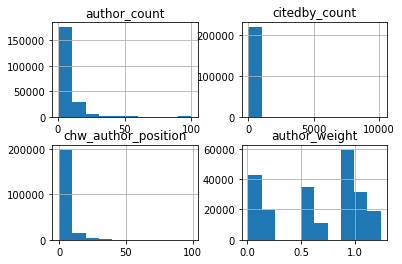

In [7]:
df_pos[['author_count', 'citedby_count', 'chw_author_position', 'author_weight']].hist()

In [8]:
df_pos = df_pos.groupby('Auid', as_index=False).agg(
    {
        'author_count': 'median',
        'citedby_count': 'median',
        'chw_author_position': 'median',
        'author_weight': ['mean', 'median'],
        'first_author': 'sum',
        'last_author': 'sum'
    }
)

# change the multiindex columns to a simple index
df_pos.columns = ['_'.join(col).strip() for col in df_pos.columns.values]

In [9]:
df_pos

,Auid_,author_count_median,citedby_count_median,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6503856044,10.0,7.0,3.0,0.355223,0.133918,7,7
1,6503905253,8.0,15.5,2.0,0.618835,0.619379,9,5
2,6503911165,8.0,21.0,4.0,0.384260,0.125299,3,1
3,6504148317,4.0,11.0,2.0,0.787197,0.986762,0,4
4,6504169150,7.0,4.5,2.0,0.575255,0.600268,17,4
...,...,...,...,...,...,...,...,...
2723,57248713000,16.0,0.0,12.0,0.062814,0.062814,0,0
2724,57249145700,7.0,0.0,3.0,0.143432,0.143432,0,0
2725,57262851900,6.0,0.0,0.0,0.985012,0.985012,1,0
2726,57266821900,3.0,0.0,2.0,1.000000,1.000000,0,1


# Get publication counts by type

In [10]:
df = pd.concat(
    [
        df_pub,
        pd.get_dummies(df_pub['subtypeDescription'])
    ],
    axis = 1
)
df

,Auid,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,...,Conference Paper,Conference Review,Data Paper,Editorial,Erratum,Letter,Note,Retracted,Review,Short Survey
0,6503856044,2-s2.0-85102936784,10.1177/10935266211001986,NaN,33749384.0,Histologic Correlates of Molecular Group 4 Ped...,re,Review,Triscott J.,60193402;60023077;60020486;60018471;60010365;1...,...,0,0,0,0,0,0,0,0,1,0
1,6503856044,2-s2.0-85108228079,10.2217/pme-2020-0120,NaN,33973801.0,Deliberations about clinical pharmacogenetic t...,re,Review,Issa A.M.,60191838;60086967;60030835;60029502;60026553;6...,...,0,0,0,0,0,0,0,0,1,0
2,6503856044,2-s2.0-85104934944,10.1002/cam4.3910,NaN,33939292.0,Trametinib therapy for children with neurofibr...,ar,Article,Ronsley R.,60023077;60010365,...,0,0,0,0,0,0,0,0,0,0
3,6503856044,2-s2.0-85109755328,10.9778/cmajo.20200212,NaN,34021014.0,Family attitudes about and experiences with me...,ar,Article,Gibbard M.,60086967,...,0,0,0,0,0,0,0,0,0,0
4,6503856044,2-s2.0-85101694285,10.1016/S2352-4642(21)00020-1,S2352464221000201,33581749.0,Prevalence and risk factors for cisplatin-indu...,ar,Article,Moke D.J.,60086967;60030769;60029311;60023077;60020565;6...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219992,57220999344,2-s2.0-85097982774,10.1002/ajmg.a.62034,NaN,33369152.0,Dual molecular diagnoses in a neurometabolic s...,ar,Article,Hannah-Shmouni F.,60031828;60017777,...,0,0,0,0,0,0,0,0,0,0
219993,57226726716,2-s2.0-85112413672,10.1093/pch/pxaa087,NaN,NaN,Factors associated with treatment failure of h...,ar,Article,D'Alessandro M.,60031828;60023790;60010363,...,0,0,0,0,0,0,0,0,0,0
219994,57241564300,2-s2.0-85100438652,10.1016/j.jcjd.2020.11.007,S1499267120304627,33549500.0,Insulin Edema Associated With Newly Diagnosed ...,ar,Article,Sawalha N.,60023790,...,0,0,0,0,0,0,0,0,0,0
219995,57249145700,2-s2.0-85114437047,10.1159/000518173,NaN,NaN,Diagnostic Dilemma in an Adolescent Girl with ...,ar,Article,Bamhraz A.A.,60031828;60026278,...,0,0,0,0,0,0,0,0,0,0


# Get SCImago Journal Rank (SJR) for publication sources

In [11]:
journals = pd.read_csv('../Datasets/scimag_journals2020.csv', delimiter = ';', low_memory = False)

# get three columns of interest
df_jrn = journals[['Title', 'SJR', 'Categories', 'H index']].rename(columns = {'H index': 'journal_h_index'})

df2 = df.merge(df_jrn, left_on = 'publicationName', right_on = 'Title')

# convert 0,xx to 0.xx
df2['SJR'] = df2['SJR'].apply(convert_eu_to_float)

df2.head()

,Auid,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,...,Erratum,Letter,Note,Retracted,Review,Short Survey,Title,SJR,Categories,journal_h_index
0,6503856044,2-s2.0-85102936784,10.1177/10935266211001986,NaN,33749384.0,Histologic Correlates of Molecular Group 4 Ped...,re,Review,Triscott J.,60193402;60023077;60020486;60018471;60010365;1...,...,0,0,0,0,1,0,Pediatric and Developmental Pathology,0.477,"Pediatrics, Perinatology and Child Health (Q2)...",60
1,6503856044,2-s2.0-85107850881,10.1177/10935266211021222,NaN,NaN,Malignant Mesothelioma With EWSR1-ATF1 Fusion ...,ar,Article,Ren H.,60028379;60023077;60021600;60019490;60008667,...,0,0,0,0,0,0,Pediatric and Developmental Pathology,0.477,"Pediatrics, Perinatology and Child Health (Q2)...",60
2,6507368744,2-s2.0-84873023233,10.2350/12-05-1204-CR.1,NaN,22901100.0,Myofibroblastoma: Report of a rare entity in t...,ar,Article,Chami R.,60030319;60016849,...,0,0,0,0,0,0,Pediatric and Developmental Pathology,0.477,"Pediatrics, Perinatology and Child Health (Q2)...",60
3,6601955128,2-s2.0-85027123847,10.1177/1093526616686008,NaN,28326958.0,Persistent left superior vena cava: A marker f...,ar,Article,Nair V.,60176051;60002306;100708789,...,0,0,0,0,0,0,Pediatric and Developmental Pathology,0.477,"Pediatrics, Perinatology and Child Health (Q2)...",60
4,6602178790,2-s2.0-84873023233,10.2350/12-05-1204-CR.1,NaN,22901100.0,Myofibroblastoma: Report of a rare entity in t...,ar,Article,Chami R.,60030319;60016849,...,0,0,0,0,0,0,Pediatric and Developmental Pathology,0.477,"Pediatrics, Perinatology and Child Health (Q2)...",60


# Group the publication statistics by author

In [12]:
# group the metrics by author
df3 = df2.groupby('Auid', as_index = False).agg(
    {
        'openaccess': 'sum',
        'Article': 'sum',
#         'Book': 'sum',
#         'Book Chapter': 'sum',
#         'Chapter': 'sum',
#         'Conference Paper': 'sum',
#         'Data Paper': 'sum',
#         'Editorial': 'sum',
#         'Erratum': 'sum',
#         'Letter': 'sum',
#         'Note': 'sum',
#         'Retracted': 'sum',
#         'Review': 'sum',
#         'Short Survey': 'sum',
        'SJR': ['median', 'mean'],
        'journal_h_index': ['median', 'mean'],
    }
)

# change the multiindex columns to a simple index
df3.columns = ['_'.join(col).strip() for col in df3.columns.values]

df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2720 entries, 0 to 2719
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Auid_                   2720 non-null   int64  
 1   openaccess_sum          2720 non-null   int64  
 2   Article_sum             2720 non-null   float64
 3   SJR_median              2720 non-null   float64
 4   SJR_mean                2720 non-null   float64
 5   journal_h_index_median  2720 non-null   float64
 6   journal_h_index_mean    2720 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 170.0 KB


,Auid_,openaccess_sum,Article_sum,SJR_median,SJR_mean,journal_h_index_median,journal_h_index_mean
0,6503856044,32,64.0,1.116,2.129307,105.0,145.443182
1,6503905253,13,19.0,1.779,2.286880,186.0,223.680000
2,6503911165,2,15.0,1.082,1.509500,120.5,171.750000
3,6504148317,0,5.0,0.805,3.676500,99.5,155.666667
4,6504169150,20,31.0,0.949,1.365558,60.0,100.883721


# Merge journal stats with authorship stats

In [13]:
df3 = df3.merge(df_pos, on='Auid_', how='inner')
df3

,Auid_,openaccess_sum,Article_sum,SJR_median,SJR_mean,journal_h_index_median,journal_h_index_mean,author_count_median,citedby_count_median,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6503856044,32,64.0,1.116,2.129307,105.0,145.443182,10.0,7.0,3.0,0.355223,0.133918,7,7
1,6503905253,13,19.0,1.779,2.286880,186.0,223.680000,8.0,15.5,2.0,0.618835,0.619379,9,5
2,6503911165,2,15.0,1.082,1.509500,120.5,171.750000,8.0,21.0,4.0,0.384260,0.125299,3,1
3,6504148317,0,5.0,0.805,3.676500,99.5,155.666667,4.0,11.0,2.0,0.787197,0.986762,0,4
4,6504169150,20,31.0,0.949,1.365558,60.0,100.883721,7.0,4.5,2.0,0.575255,0.600268,17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,57241564300,0,1.0,0.900,0.900000,37.0,37.000000,2.0,0.0,1.0,1.241007,1.241007,0,1
2716,57248713000,0,0.0,3.216,3.216000,243.0,243.000000,16.0,0.0,12.0,0.062814,0.062814,0,0
2717,57249145700,0,1.0,0.951,0.951000,72.0,72.000000,7.0,0.0,3.0,0.143432,0.143432,0,0
2718,57266821900,1,0.0,1.241,1.241000,153.0,153.000000,3.0,0.0,2.0,1.000000,1.000000,0,1


# Get author profiles

In [14]:
df_profiles = pd.read_json('../Datasets/chw_author_profiles_jan12.json')
# df_ucal = pd.read_excel('../Datasets/ucalgary_author_profiles.xlsx')

# df_ucal.info()
df_profiles.info()

# df_ucal.head()
df_profiles.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2493 entries, 0 to 2492
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Auid                     2493 non-null   int64  
 1   filled_cum_citations     2493 non-null   object 
 2   mean_citations_per_year  2493 non-null   float64
 3   citation_count           2493 non-null   int64  
 4   cited_by_count           2493 non-null   int64  
 5   coauthor_count           2493 non-null   int64  
 6   classificationgroup      2493 non-null   object 
 7   document_count           2493 non-null   int64  
 8   given_name               2493 non-null   object 
 9   h_index                  2493 non-null   int64  
 10  indexed_name             2493 non-null   object 
 11  publication_range        2493 non-null   object 
 12  subject_areas            2493 non-null   object 
 13  surname                  2493 non-null   object 
dtypes: float64(1), int64(6),

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,given_name,h_index,indexed_name,publication_range,subject_areas,surname
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,Samer M.,18,Adeeb S.,"(2004, 2021)","[Subjectarea(area='Physiology (medical)', abbr...",Adeeb
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,Jason P.,35,Acker J.,"(1996, 2021)","[Subjectarea(area='Biochemistry', abbreviation...",Acker
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,Babita,23,Agrawal B.,"(1991, 2020)",[Subjectarea(area='Immunology and Microbiology...,Agrawal
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,Kim D.,9,Adams K.,"(2009, 2020)",[Subjectarea(area='Human-Computer Interaction'...,Adams
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,Samina,24,Ali S.,"(2003, 2021)","[Subjectarea(area='Fundamentals and Skills', a...",Ali


# Merge with CHW ids to get affiliation

In [15]:
affils = pd.read_excel('../Datasets/chw_ids.xlsx', index_col=0)
affils.drop('OBRIEN', axis = 1, inplace = True)
affils.info()
affils.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2524 entries, 0 to 2523
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Auid      2524 non-null   int64
 1   WCHRI     2524 non-null   int64
 2   ACHRI     2524 non-null   int64
 3   BCCHR     2524 non-null   int64
 4   CHRIM     2524 non-null   int64
 5   CHUSJ     2524 non-null   int64
 6   MCMASTER  2524 non-null   int64
 7   Sickkids  2524 non-null   int64
dtypes: int64(8)
memory usage: 177.5 KB


,Auid,WCHRI,ACHRI,BCCHR,CHRIM,CHUSJ,MCMASTER,Sickkids
0,7007033627,1,0,0,0,0,0,0
1,12902675100,1,0,0,0,0,0,0
2,6603220065,1,0,0,0,0,0,0
3,16688012700,1,0,0,0,0,0,0
4,7003415672,1,0,0,0,0,0,0


In [16]:
affils.drop_duplicates(inplace=True)

In [17]:
af = affils.melt(
    'Auid', 
    var_name = 'affil'
).query(
    'value == 1'
).groupby(
    'Auid'
)[
    'affil'
].apply(
    ', '.join
).reset_index()

df_profiles = pd.merge(df_profiles, af, on = 'Auid')

# remove overlap between UCalgary and CHW authors
# df_ucal = df_ucal[~df_ucal['Auid'].isin(df_profiles['Auid'])]

# combine the profile dataframes
# df_profiles = pd.concat([df_profiles, df_ucal])
df_profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 0 to 2232
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Auid                     2233 non-null   int64  
 1   filled_cum_citations     2233 non-null   object 
 2   mean_citations_per_year  2233 non-null   float64
 3   citation_count           2233 non-null   int64  
 4   cited_by_count           2233 non-null   int64  
 5   coauthor_count           2233 non-null   int64  
 6   classificationgroup      2233 non-null   object 
 7   document_count           2233 non-null   int64  
 8   given_name               2233 non-null   object 
 9   h_index                  2233 non-null   int64  
 10  indexed_name             2233 non-null   object 
 11  publication_range        2233 non-null   object 
 12  subject_areas            2233 non-null   object 
 13  surname                  2233 non-null   object 
 14  affil                   

# Count current and past affiliations

In [18]:
# count the past and present affiliations
# df_profiles['total_current_affiliations'] = df_profiles['affiliation_current'].str.findall('(Affiliation)\(').apply(count_affils)
# df_profiles['total_past_affiliations'] = df_profiles['affiliation_history'].str.findall('(Affiliation)\(').apply(count_affils)

# get the number of years publishing
df_profiles['first_publication'] = df_profiles['publication_range'].str.extract('\(([0-9]*), ').astype(int)
df_profiles['last_publication'] = df_profiles['publication_range'].str.extract(', ([0-9]*)\)').astype(int)

df_profiles['publication_duration'] = df_profiles['last_publication'] - df_profiles['first_publication']

# get dummy variable for whether the orcid was reported or not
# df_profiles['ORCID'] = np.where(df_profiles['orcid'].notna(), 1, 0)

df_profiles.head()

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,given_name,h_index,indexed_name,publication_range,subject_areas,surname,affil,first_publication,last_publication,publication_duration
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,Samer M.,18,Adeeb S.,"(2004, 2021)","[Subjectarea(area='Physiology (medical)', abbr...",Adeeb,WCHRI,2004,2021,17
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,Jason P.,35,Acker J.,"(1996, 2021)","[Subjectarea(area='Biochemistry', abbreviation...",Acker,WCHRI,1996,2021,25
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,Babita,23,Agrawal B.,"(1991, 2020)",[Subjectarea(area='Immunology and Microbiology...,Agrawal,WCHRI,1991,2020,29
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,Kim D.,9,Adams K.,"(2009, 2020)",[Subjectarea(area='Human-Computer Interaction'...,Adams,WCHRI,2009,2020,11
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,Samina,24,Ali S.,"(2003, 2021)","[Subjectarea(area='Fundamentals and Skills', a...",Ali,WCHRI,2003,2021,18


In [19]:
df_profiles.columns

Index(['Auid', 'filled_cum_citations', 'mean_citations_per_year',
       'citation_count', 'cited_by_count', 'coauthor_count',
       'classificationgroup', 'document_count', 'given_name', 'h_index',
       'indexed_name', 'publication_range', 'subject_areas', 'surname',
       'affil', 'first_publication', 'last_publication',
       'publication_duration'],
      dtype='object')

In [20]:
df_profiles.drop(
    [
        'given_name',
        'publication_range',
        'surname',
        'first_publication',
        'last_publication'
    ], 
    axis = 1, 
    inplace = True
)

df_profiles.head()

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,subject_areas,affil,publication_duration
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,18,Adeeb S.,"[Subjectarea(area='Physiology (medical)', abbr...",WCHRI,17
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,35,Acker J.,"[Subjectarea(area='Biochemistry', abbreviation...",WCHRI,25
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,23,Agrawal B.,[Subjectarea(area='Immunology and Microbiology...,WCHRI,29
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,9,Adams K.,[Subjectarea(area='Human-Computer Interaction'...,WCHRI,11
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,24,Ali S.,"[Subjectarea(area='Fundamentals and Skills', a...",WCHRI,18


# Compute the linear growth rate in cumulative citations

In [21]:
df_profiles.loc[0, 'filled_cum_citations']

[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622.0, 669.0, 755.0, 810.0, 814.0]

In [24]:
def linear_growth(col):
    """ Accepts a column of cumulative summed values and approximates
        the linear growth rate. The growth rate is approximated over
        the period of 2011-2021 as follows:
        
        - if all elements are nonzero, compute (max - min)/length
        - if all elements are zero, return 0
        - if there are leading zeros
            - find the index of the first nonzero element
            - max is the last element of the array
            - min is the last zero before the nonzero element(s)
            - compute (max - min)/len(nonzero)
    """
    col = np.array(col)
       
    # find if all entries are zero
    if int(sum(col)) == 0:
        return 0
    
    try:
        # find the zeros - col is integer valued
        zero_index = np.argwhere(col < 1)[0][0]
        
        return (np.max(col) - col[zero_index])/len(np.argwhere(col > 0) + 1)
        
    except IndexError:  # this happens when no zeros are found
        return (np.max(col) - np.min(col))/len(col)
    

In [27]:
df_profiles['growth_rate'] = df_profiles['filled_cum_citations'].apply(linear_growth)
df_profiles.head()

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,subject_areas,affil,publication_duration,growth_rate
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,18,Adeeb S.,"[Subjectarea(area='Physiology (medical)', abbr...",WCHRI,17,72.818182
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,35,Acker J.,"[Subjectarea(area='Biochemistry', abbreviation...",WCHRI,25,180.454545
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,23,Agrawal B.,[Subjectarea(area='Immunology and Microbiology...,WCHRI,29,20.900000
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,9,Adams K.,[Subjectarea(area='Human-Computer Interaction'...,WCHRI,11,19.363636
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,24,Ali S.,"[Subjectarea(area='Fundamentals and Skills', a...",WCHRI,18,122.454545


In [28]:
df_profiles['growth_rate'].max()

9630.454545454546

In [29]:
df_profiles['growth_rate'].fillna(0, inplace=True)
df_profiles['growth_rate'].replace({np.inf: 0}, inplace=True)

In [30]:
df_profiles

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,subject_areas,affil,publication_duration,growth_rate
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,18,Adeeb S.,"[Subjectarea(area='Physiology (medical)', abbr...",WCHRI,17,72.818182
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,35,Acker J.,"[Subjectarea(area='Biochemistry', abbreviation...",WCHRI,25,180.454545
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,23,Agrawal B.,[Subjectarea(area='Immunology and Microbiology...,WCHRI,29,20.900000
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,9,Adams K.,[Subjectarea(area='Human-Computer Interaction'...,WCHRI,11,19.363636
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,24,Ali S.,"[Subjectarea(area='Fundamentals and Skills', a...",WCHRI,18,122.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,57226682225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,25,"[(2716, 1), (2736, 1), (2700, 1)]",1,0,McLean L.,"[Subjectarea(area='Genetics (clinical)', abbre...",Sickkids,0,0.000000
2229,57283733600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,7,"[(2720, 1)]",1,0,Patterson S.,"[Subjectarea(area='Hematology', abbreviation='...",MCMASTER,0,0.000000
2230,57262851900,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,5,"[(2911, 1), (2719, 1), (2718, 1), (3605, 1)]",1,0,Marquis M.,"[Subjectarea(area='Leadership and Management',...",CHUSJ,0,0.000000
2231,57249145700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.272727,0,0,6,"[(2748, 1), (2737, 1), (2727, 1), (1314, 1)]",1,0,Rodrigues A.,"[Subjectarea(area='Urology', abbreviation='MED...",MCMASTER,0,3.000000


# Merge the author profile stats with stats from publications

In [31]:
df3

,Auid_,openaccess_sum,Article_sum,SJR_median,SJR_mean,journal_h_index_median,journal_h_index_mean,author_count_median,citedby_count_median,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6503856044,32,64.0,1.116,2.129307,105.0,145.443182,10.0,7.0,3.0,0.355223,0.133918,7,7
1,6503905253,13,19.0,1.779,2.286880,186.0,223.680000,8.0,15.5,2.0,0.618835,0.619379,9,5
2,6503911165,2,15.0,1.082,1.509500,120.5,171.750000,8.0,21.0,4.0,0.384260,0.125299,3,1
3,6504148317,0,5.0,0.805,3.676500,99.5,155.666667,4.0,11.0,2.0,0.787197,0.986762,0,4
4,6504169150,20,31.0,0.949,1.365558,60.0,100.883721,7.0,4.5,2.0,0.575255,0.600268,17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,57241564300,0,1.0,0.900,0.900000,37.0,37.000000,2.0,0.0,1.0,1.241007,1.241007,0,1
2716,57248713000,0,0.0,3.216,3.216000,243.0,243.000000,16.0,0.0,12.0,0.062814,0.062814,0,0
2717,57249145700,0,1.0,0.951,0.951000,72.0,72.000000,7.0,0.0,3.0,0.143432,0.143432,0,0
2718,57266821900,1,0.0,1.241,1.241000,153.0,153.000000,3.0,0.0,2.0,1.000000,1.000000,0,1


In [32]:
df_stats = pd.merge(df_profiles, df3, left_on = 'Auid', right_on = 'Auid_')
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2220 entries, 0 to 2219
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Auid                        2220 non-null   int64  
 1   filled_cum_citations        2220 non-null   object 
 2   mean_citations_per_year     2220 non-null   float64
 3   citation_count              2220 non-null   int64  
 4   cited_by_count              2220 non-null   int64  
 5   coauthor_count              2220 non-null   int64  
 6   classificationgroup         2220 non-null   object 
 7   document_count              2220 non-null   int64  
 8   h_index                     2220 non-null   int64  
 9   indexed_name                2220 non-null   object 
 10  subject_areas               2220 non-null   object 
 11  affil                       2220 non-null   object 
 12  publication_duration        2220 non-null   int64  
 13  growth_rate                 2220 

In [33]:
df_stats

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,...,SJR_mean,journal_h_index_median,journal_h_index_mean,author_count_median,citedby_count_median,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,18,Adeeb S.,...,0.620788,49.0,69.212121,5.0,2.0,3.0,0.788131,0.984583,11,79
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,35,Acker J.,...,1.032665,85.0,118.451613,5.0,13.0,2.0,0.762061,0.985012,18,70
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,23,Agrawal B.,...,2.063717,161.0,200.233333,5.0,14.0,2.0,0.766865,0.985616,16,24
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,9,Adams K.,...,0.526057,41.0,41.600000,4.0,3.0,1.0,0.785031,0.811536,11,10
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,24,Ali S.,...,1.127458,75.0,114.672897,8.0,5.5,2.5,0.620556,0.619379,22,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,57241564300,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,1,"[(1310, 1), (2712, 1), (2724, 1)]",1,0,Geddie H.,...,0.900000,37.0,37.000000,2.0,0.0,1.0,1.241007,1.241007,0,1
2216,57226682225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,25,"[(2716, 1), (2736, 1), (2700, 1)]",1,0,McLean L.,...,1.274000,110.0,110.000000,26.0,0.0,11.0,0.038462,0.038462,0,0
2217,57283733600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,7,"[(2720, 1)]",1,0,Patterson S.,...,1.970000,188.0,188.000000,8.0,0.0,1.0,0.562500,0.562500,0,0
2218,57249145700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.272727,0,0,6,"[(2748, 1), (2737, 1), (2727, 1), (1314, 1)]",1,0,Rodrigues A.,...,0.951000,72.0,72.000000,7.0,0.0,3.0,0.143432,0.143432,0,0


In [34]:
top10 = df_stats['cited_by_count'].quantile(q=.9)

df_stats[df_stats['cited_by_count'] >= top10]

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,...,SJR_mean,journal_h_index_median,journal_h_index_mean,author_count_median,citedby_count_median,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
17,7003777149,"[837.0, 2148.0, 4030.0, 5810.0, 8297.0, 9492.0...",1280.818182,24365,16197,3591,"[(1502, 1), (2736, 4), (2746, 8), (1314, 1), (...",448,79,Bagshaw S.,...,2.293738,112.5,159.406417,6.0,20.0,2.0,0.697793,0.983649,112,132
19,7006668487,"[5250.0, 7043.0, 9853.0, 11171.0, 12029.0, 129...",1504.545455,27439,14392,903,"[(2732, 30), (2914, 2), (2746, 12), (3003, 2),...",346,73,Baracos V.,...,2.331646,140.0,172.028939,6.0,28.0,3.0,0.710343,0.983731,57,141
21,35507973100,"[1057.0, 1876.0, 2232.0, 2565.0, 2769.0, 2910....",305.545455,15441,11477,368,"[(2712, 4), (3204, 1), (1203, 1), (1310, 4), (...",168,49,Beaulieu C.,...,1.955534,191.0,194.186335,5.0,26.0,3.0,0.752068,0.984262,15,81
30,6603756781,"[179.0, 406.0, 1204.0, 2442.0, 2640.0, 2824.0,...",355.818182,6488,5579,622,"[(2730, 85), (2700, 3), (2502, 1), (3004, 3), ...",159,36,Brandwein J.,...,2.738026,119.0,187.405229,9.0,16.5,4.0,0.478015,0.543561,19,29
67,7005933822,"[530.0, 1099.0, 1937.0, 2281.0, 2629.0, 2961.0...",326.818182,9957,7219,590,"[(2400, 1), (2704, 1), (2737, 33), (1312, 13),...",270,56,Davidge S.,...,1.810239,197.0,186.584314,5.0,22.0,3.0,0.789255,0.985616,22,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,57203102859,"[200.0, 712.0, 1104.0, 1514.0, 1946.0, 2678.0,...",296.727273,15185,10633,1159,"[(2739, 17), (2917, 8), (2712, 11), (2746, 6),...",489,59,Barr R.,...,2.080718,105.0,161.015789,4.0,12.0,2.0,0.818388,0.985616,179,193
2104,57204409408,"[490.0, 800.0, 2820.0, 3082.0, 3568.0, 3569.0,...",356.909091,8243,6978,694,"[(2800, 28), (2722, 1), (2804, 14), (2700, 7),...",108,35,Hazrati L.,...,2.646347,181.5,186.571429,5.5,14.0,2.0,0.629795,0.600268,17,26
2105,57204345472,"[648.0, 1151.0, 1309.0, 2336.0, 11086.0, 13514...",1583.090909,16657,15226,2893,"[(2742, 2), (2730, 2), (2737, 1), (2713, 6), (...",124,38,DeVeber G.,...,2.163356,105.0,180.913462,9.0,13.0,5.0,0.488228,0.550000,6,31
2144,57211089486,"[242.0, 630.0, 806.0, 981.0, 1216.0, 1239.0, 1...",119.909091,10745,7448,808,"[(2721, 34), (1305, 1), (1303, 9), (1100, 3), ...",243,53,Álvarez F.,...,2.393269,135.0,176.741294,5.0,14.0,3.0,0.799634,0.985616,42,133


# Save the data for PCA

In [35]:
df_stats.columns

Index(['Auid', 'filled_cum_citations', 'mean_citations_per_year',
       'citation_count', 'cited_by_count', 'coauthor_count',
       'classificationgroup', 'document_count', 'h_index', 'indexed_name',
       'subject_areas', 'affil', 'publication_duration', 'growth_rate',
       'Auid_', 'openaccess_sum', 'Article_sum', 'SJR_median', 'SJR_mean',
       'journal_h_index_median', 'journal_h_index_mean', 'author_count_median',
       'citedby_count_median', 'chw_author_position_median',
       'author_weight_mean', 'author_weight_median', 'first_author_sum',
       'last_author_sum'],
      dtype='object')

In [37]:
df_stats.dropna(inplace=True)

In [38]:
df_stats.drop(
    [
        'Auid_',
        'indexed_name',
        'subject_areas',
        'classificationgroup',
        'author_weight_mean',
        'SJR_mean',
        'journal_h_index_mean',
        'filled_cum_citations'
    ],
    axis=1,
    inplace=True
)

In [39]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2219 entries, 0 to 2219
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Auid                        2219 non-null   int64  
 1   mean_citations_per_year     2219 non-null   float64
 2   citation_count              2219 non-null   int64  
 3   cited_by_count              2219 non-null   int64  
 4   coauthor_count              2219 non-null   int64  
 5   document_count              2219 non-null   int64  
 6   h_index                     2219 non-null   int64  
 7   affil                       2219 non-null   object 
 8   publication_duration        2219 non-null   int64  
 9   growth_rate                 2219 non-null   float64
 10  openaccess_sum              2219 non-null   int64  
 11  Article_sum                 2219 non-null   float64
 12  SJR_median                  2219 non-null   float64
 13  journal_h_index_median      2219 

# Fix the doubled affiliations

In [40]:
df_stats['affil'].unique()

array(['WCHRI', 'WCHRI, ACHRI', 'BCCHR', 'ACHRI', 'MCMASTER', 'Sickkids',
       'CHUSJ', 'CHRIM', 'MCMASTER, Sickkids', 'BCCHR, Sickkids'],
      dtype=object)

In [41]:
df_stats['affil'].replace({'MCMASTER, Sickkids': 'McMaster', 'MCMASTER': 'McMaster', 'BCCHR, Sickkids': 'BCCHR', 'WCHRI, ACHRI': 'ACHRI'}, inplace=True)

In [42]:
df_stats['affil'].unique()

array(['WCHRI', 'ACHRI', 'BCCHR', 'McMaster', 'Sickkids', 'CHUSJ',
       'CHRIM'], dtype=object)

In [43]:
# # scale everything to be used in PCA to the interval [0,1]
# cols = list(df_stats.columns)

# # remove Auid and affil
# cols.remove('Auid')
# cols.remove('affil')

# for col in cols:
#     df_stats[col] = (df_stats[col] - df_stats[col].min())/(df_stats[col].max() - df_stats[col].min())

In [44]:
df_stats

,Auid,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,document_count,h_index,affil,publication_duration,growth_rate,openaccess_sum,Article_sum,SJR_median,journal_h_index_median,author_count_median,citedby_count_median,chw_author_position_median,author_weight_median,first_author_sum,last_author_sum
0,6603220065,74.000000,1038,800,239,168,18,WCHRI,17,72.818182,22,97.0,0.4495,49.0,5.0,2.0,3.0,0.984583,11,79
1,7007033627,190.090909,3837,2552,476,166,35,WCHRI,25,180.454545,32,127.0,0.9240,85.0,5.0,13.0,2.0,0.985012,18,70
2,16688012700,19.000000,1702,1361,66,65,23,WCHRI,29,20.900000,20,51.0,1.8600,161.0,5.0,14.0,2.0,0.985616,16,24
3,12902675100,23.545455,287,170,76,46,9,WCHRI,11,19.363636,2,27.0,0.3900,41.0,4.0,3.0,1.0,0.811536,11,10
4,55366878700,133.454545,1643,1273,438,128,24,WCHRI,18,122.454545,57,84.0,0.8580,75.0,8.0,5.5,2.5,0.619379,22,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,57241564300,0.000000,0,0,1,1,0,McMaster,0,0.000000,0,1.0,0.9000,37.0,2.0,0.0,1.0,1.241007,0,1
2216,57226682225,0.000000,0,0,25,1,0,Sickkids,0,0.000000,1,1.0,1.2740,110.0,26.0,0.0,11.0,0.038462,0,0
2217,57283733600,0.000000,0,0,7,1,0,McMaster,0,0.000000,1,0.0,1.9700,188.0,8.0,0.0,1.0,0.562500,0,0
2218,57249145700,0.272727,0,0,6,1,0,McMaster,0,3.000000,0,1.0,0.9510,72.0,7.0,0.0,3.0,0.143432,0,0


# Rename confusing columns

In [45]:
df_stats.rename(
    columns={
        'citedby_count_median': 'median_citations_per_doc'
    },
    inplace=True
)

In [46]:
df_stats.corr()

,Auid,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,document_count,h_index,publication_duration,growth_rate,openaccess_sum,Article_sum,SJR_median,journal_h_index_median,author_count_median,median_citations_per_doc,chw_author_position_median,author_weight_median,first_author_sum,last_author_sum
Auid,1.000000,-0.082901,-0.147943,-0.155030,-0.087735,-0.232675,-0.332594,-0.473239,-0.065465,-0.183214,-0.221848,-0.001907,-0.107780,0.123964,-0.152722,0.026416,-0.081602,-0.153314,-0.202058
mean_citations_per_year,-0.082901,1.000000,0.785667,0.800824,0.652759,0.639915,0.560399,0.211382,0.996036,0.730045,0.585907,0.118943,0.091881,0.066002,0.128272,0.126266,-0.032996,0.524715,0.572816
citation_count,-0.147943,0.785667,1.000000,0.989084,0.626394,0.822369,0.833352,0.461775,0.762648,0.819551,0.786112,0.171873,0.220576,0.007847,0.291679,0.128994,0.026343,0.585721,0.746345
cited_by_count,-0.155030,0.800824,0.989084,1.000000,0.646864,0.812057,0.824552,0.470439,0.781666,0.819890,0.776307,0.174854,0.220159,0.011597,0.287044,0.133487,0.016622,0.600118,0.732898
coauthor_count,-0.087735,0.652759,0.626394,0.646864,1.000000,0.574536,0.560019,0.293379,0.649100,0.612884,0.535786,0.129623,0.104836,0.156995,0.129413,0.217961,-0.118962,0.375693,0.451609
document_count,-0.232675,0.639915,0.822369,0.812057,0.574536,1.000000,0.889312,0.594094,0.608970,0.847369,0.952827,0.031442,0.102526,-0.047509,0.157287,0.104452,0.090495,0.725307,0.903594
h_index,-0.332594,0.560399,0.833352,0.824552,0.560019,0.889312,1.000000,0.703481,0.523516,0.805130,0.870901,0.179172,0.280565,-0.016345,0.349627,0.147642,0.052691,0.601289,0.769924
publication_duration,-0.473239,0.211382,0.461775,0.470439,0.293379,0.594094,0.703481,1.000000,0.186679,0.436471,0.569990,0.028634,0.190943,-0.156737,0.243897,0.025087,0.145825,0.458592,0.544248
growth_rate,-0.065465,0.996036,0.762648,0.781666,0.649100,0.608970,0.523516,0.186679,1.000000,0.707657,0.554249,0.114534,0.081786,0.071811,0.115035,0.126025,-0.039043,0.513257,0.548581
openaccess_sum,-0.183214,0.730045,0.819551,0.819890,0.612884,0.847369,0.805130,0.436471,0.707657,1.000000,0.881262,0.160944,0.200809,0.036366,0.197295,0.167800,0.027199,0.643819,0.778449


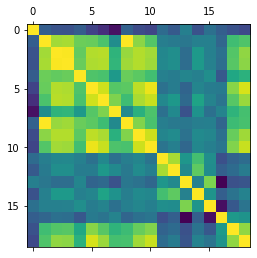

In [47]:
import matplotlib.pyplot as plt

plt.matshow(df_stats.corr())
plt.show()

In [58]:
df_stats.loc[2163, :]

Auid                          57214265741
mean_citations_per_year          0.000000
citation_count                        264
cited_by_count                        264
coauthor_count                         12
document_count                          1
h_index                                 1
affil                            Sickkids
publication_duration                    0
growth_rate                      0.000000
openaccess_sum                          0
Article_sum                      1.000000
SJR_median                      15.993000
journal_h_index_median        1226.000000
author_count_median             13.000000
median_citations_per_doc       264.000000
chw_author_position_median       4.000000
author_weight_median             0.076929
first_author_sum                        0
last_author_sum                         0
Name: 2163, dtype: object

In [48]:
df_stats.to_excel('../Datasets/PCA_inputs_jan13.xlsx', index=False)

In [54]:
df_stats.to_excel('/media/Bibliometrics/matt analysis/PCA_inputs_jan13.xlsx', index=False)

# Lemmatize keywords and locate BiGrams/TriGrams

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
def get_keywords(df, affiliation = None):
    """ Accepts a DataFrame and affiliation and gets keywords. """
    
    keys = df[['CHW author', 'authkeywords', 'affil']]
    
    if affiliation:
        keys = keys[keys['affil'] == affiliation]
        
    # remove missing rows
    keys = keys[~keys['authkeywords'].isna()]

    # group keywords by author
    keys = keys.groupby('CHW author', as_index = False).agg({'authkeywords': ' | '.join})
    
    # split the keywords by '|'
    keys['keywords'] = keys['authkeywords'].apply(
        str.lower
    ).str.split(
        '|'
    ).apply(   # remove leading and trailing whitespace from keywords
        lambda words: [x.strip() for x in words]
    ).apply(   # replace special characters # $ * %
        lambda words: [x.replace(
            '#', ''
        ).replace(
            '#', ''
        ).replace(
            '$', ''
        ).replace(
            '*', ''
        ).replace(
            ',', ''
        ).replace(
            '"', ''
        ).replace(
            '%', ''
        ).replace("'", '') for x in words ]
    )

    # getting lemmas for single-word keywords
    keys['single_lemmas'] = keys['keywords'].apply(
        lambda x: [lemmatizer.lemmatize(word) for word in x if ' ' not in word]
    ).apply(   # apply my custom wordmap to the single keywords
        lambda x: [wordmap[word] if word in wordmap.keys() else word for word in x]
    )

    # lemmatize keyphrases
    keys['keyphrases'] = keys['keywords'].apply(
        lambda words: [word for word in words if ' ' in word]
    ).apply(
        lambda words: [word.split() for word in words]
    ).apply(   # replace special characters # $ * %
        lambda words: [[x.replace('#', '').replace('#', '').replace('$', '').replace('*', '').replace(',', '').replace('"', '').replace('%', '').replace("'", '') for x in sublist] for sublist in words]
    ).apply(   # lemmatize single words from keyphrases
        lambda words: [[lemmatizer.lemmatize(x) for x in sublist] for sublist in words]
    ).apply(
        lambda words: [[' '.join(sublist)] for sublist in words]
    ).apply(
        lambda words: [wordmap[word] if word in wordmap.keys() else word for sublist in words for word in sublist]
    )

    # join all single word lemmas with lemmatized keyphrases
    keys['lemmas'] = keys['single_lemmas'].apply(lambda x: ','.join(x)) + keys['keyphrases'].apply(lambda x: ','.join(x))
        
    return ','.join(keys['lemmas'].to_list()).split(',')

def get_word_frequency(lemmas):
    """ Accepts a string of comma-separated lemmas and  
        returns DataFrame of word frequency counts.
    """
    
    # get a frequency distribution of the keywords
    doc = FreqDist(lemmas)

    return pd.DataFrame(
        dict(doc).items(),
        columns = ['Word', 'Count']
    )

def get_top(word_freq, n = 75):
    """ Accepts a list of word frequencies and returns the top n words 
        in a space-separated string.
        ONLY USED TO GENERATE WORDS FOR THE WORDCLOUDS
    """
    
    import random
    
    topkeywords = word_freq.nlargest(n, 'Count')
    top = [(word + ',')*num for word, num in zip(topkeywords['Word'], topkeywords['Count'])]
    
    top = [substr.split(',') for substr in top]
    
    # flatten the list
    top = [word for sublist in top for word in sublist]
    random.shuffle(top)
    
    return top

def plot_word_freq(word_freq, n = 25, affiliation = 'All Sites'):
    """ Accepts a DataFrame of word frequencies and plots the 
        word frequency bar chart.
    """
    
    # get the top 25 keywords
    top_n = word_freq.nlargest(n, 'Count')

    # plot the top keywords by frequency
    fig = px.bar(
        top_n,
        x = 'Word',
        y = 'Count',
        title = 'Top {} Keywords - {}'.format(n, affiliation)
    )

    fig.update_layout(
        height = 800,
        width = 1400,
        font = dict(size = 24)
    )

    fig.update_xaxes(
        tickangle = 315
    )

    fig.show()

def plot_wordcloud(top_n, affiliation = 'All Sites'):
    """ Accepts a DataFrame and affilation and plots wordcloud. """
    
    wordcloud = WordCloud(max_words = 85000, max_font_size = 256, background_color = "white", scale = 2.5, colormap = 'viridis').generate(' '.join(top_n))
    
    plt.figure(figsize = [28, 14])
    plt.imshow(wordcloud, interpolation='bilinear')


    plt.axis("off")
    plt.savefig('{}_wordcloud.png'.format(affiliation), opts = dict(format = 'png', bbox_inches = 'tight', pad_inches = 0))
    plt.show()

In [ ]:
df4 = pd.merge(df2, af, left_on = 'CHW author', right_on = 'Auid')

In [ ]:
# affiliation1 = 'Sickkids'
affiliation2 = 'All Sites'

# get the keywords
lemmas = get_keywords(df4)

# get word frequencies
word_freq = get_word_frequency(lemmas)

# get top n words for wordcloud
n = 75
topn = get_top(word_freq, n = n)

# plot the top 10 words - don't forget to save it!
plot_word_freq(word_freq, n = 30, affiliation = affiliation2)

# plot the wordcloud
plot_wordcloud(topn, affiliation = affiliation2)

In [ ]:
# isolate the keywords
keys = df4[['CHW author', 'authkeywords', 'affil']]

In [ ]:
# used only for wordclouds for single site
keys = keys[keys['affil'] == 'WCHRI']

In [ ]:
# remove missing rows
keys = keys[~keys['authkeywords'].isna()]

# group keywords by author
keys = keys.groupby('CHW author', as_index = False).agg({'authkeywords': ' | '.join})

# split the keywords by '|'
keys['keywords'] = keys['authkeywords'].apply(
    str.lower
).str.split(
    '|'
).apply(   # remove leading and trailing whitespace from keywords
    lambda words: [x.strip() for x in words]
).apply(   # replace special characters # $ * %
    lambda words: [x.replace(
        '#', ''
    ).replace(
        '#', ''
    ).replace(
        '$', ''
    ).replace(
        '*', ''
    ).replace(
        ',', ''
    ).replace(
        '"', ''
    ).replace(
        '%', ''
    ).replace("'", '') for x in words ]
)

# getting lemmas for single-word keywords
keys['single_lemmas'] = keys['keywords'].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in x if ' ' not in word]
).apply(   # apply my custom wordmap to the single keywords
    lambda x: [wordmap[word] if word in wordmap.keys() else word for word in x]
)

# lemmatize keyphrases
keys['keyphrases'] = keys['keywords'].apply(
    lambda words: [word for word in words if ' ' in word]
).apply(
    lambda words: [word.split() for word in words]
).apply(   # replace special characters # $ * %
    lambda words: [[x.replace('#', '').replace('#', '').replace('$', '').replace('*', '').replace(',', '').replace('"', '').replace('%', '').replace("'", '') for x in sublist] for sublist in words]
).apply(   # lemmatize single words from keyphrases
    lambda words: [[lemmatizer.lemmatize(x) for x in sublist] for sublist in words]
).apply(
    lambda words: [[' '.join(sublist)] for sublist in words]
).apply(
    lambda words: [wordmap[word] if word in wordmap.keys() else word for sublist in words for word in sublist]
)

# join all single word lemmas with lemmatized keyphrases
keys['lemmas'] = keys['single_lemmas'].apply(lambda x: ','.join(x)) + keys['keyphrases'].apply(lambda x: ','.join(x))

keys.head()

In [ ]:
# towards getting a list of unique lemmatized keywords and keyphrases
unique_lemmas = list(set(','.join(keys['lemmas'].to_list()).split(',')))


print(unique_lemmas[:100])
print('\nFound {} unique lemmas and lemmatized keyphrases'.format(len(unique_lemmas)))

## Honing the wordmap

In [ ]:
lemmas = ','.join(keys['lemmas'].to_list()).split(',')
print(lemmas[:100])

# get a frequency distribution of the keywords
doc = FreqDist(lemmas)

word_freq = pd.DataFrame(
    dict(doc).items(),
    columns = ['Word', 'Count']
)

word_freq.info()

In [ ]:
word_freq.to_csv('wchri_word_freq.csv', index = False)

In [ ]:
# get the top 25 keywords
top10_keywords = word_freq.nlargest(10, 'Count')

# plot the top keywords by frequency
fig = px.bar(
    top10_keywords,
    x = 'Word',
    y = 'Count',
    title = 'Top 10 Keywords - WCHRI'
)

fig.update_layout(
    height = 800,
    width = 1400,
    font = dict(size = 24)
)

fig.update_xaxes(
    tickangle = 315
)

fig.show()

In [ ]:
top75 = get_top(word_freq, 75)

In [ ]:
wordcloud = WordCloud(max_words = 85000, max_font_size = 256, background_color = "white", scale = 2.5, colormap = 'viridis').generate(' '.join(top75))

In [ ]:
plt.figure(figsize = [28, 14])
plt.imshow(wordcloud, interpolation='bilinear')


plt.axis("off")
plt.savefig('wchri_wordcloud.png', opts = dict(format = 'png', bbox_inches = 'tight', pad_inches = 0))
plt.show()


In [ ]:
wordmap2 = pd.DataFrame(unique_lemmas, columns = ['Word']).sort_values(by = 'Word')
wordmap2.drop(0, axis = 0, inplace = True)
wordmap2

In [ ]:
wordmap2.to_csv('wordmap2.csv', index = False)

### Considerations

There are many keywords that are slight variations on the same underlying concept. For example, `diabetes type 1` and `diabetes mellitus type 1`. In order to consolidate the number of keywords into themes, I'm going to take the first word of multi-word keywords and see if I can cluster keywords around them.

In [ ]:
lemmatizer.lemmatize('subtypes')

In [ ]:
# while this may change the meanings of some keywords i.e. lgbtq+ -> lgbtq, remove all punctuation/special characters from the sentences
tokens = [re.sub('[\W_]+', ' ', sentence) for sentence in key_tokens]

# replace any extra whitespace with single spaces
tokens = [' '.join(word.split()) for word in tokens]
print(tokens[:100])

## Lemmatize each word of the keyphrases, then join the words back together

In [ ]:
single_words = [word for word in tokens if not ' ' in word]
print(single_words[:100])

In [ ]:
phrases = [word for word in tokens if ' ' in word]

print(len(tokens))
print(len(single_words), len(phrases), len(single_words) + len(phrases))

In [ ]:
# create the lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
lemmas_single = [lemmatizer.lemmatize(word) for word in single_words]

In [ ]:
print(lemmas_single[:100])

In [ ]:
# put the lemmatized keyphrases back together
keys = [' '.join(lemmas) for lemmas in keyphrase_lemmas]
keys[:10]

In [ ]:
# get the keywords that are just 1 word
single_words = [word for word in keywords if not r'\s' in word]

# remove stopwords and punctuation
# single_words = [word.translate(string.punctuation) for word in single_words if not word in stop_words]

# single_word_lemmas = [lemmatizer.lemmatize(word) for word in single_words]
# unique_single_words = list(set(single_word_lemmas))

# print('After lemmatization, there are {} unique single keywords'.format(len(Counter(unique_single_words))))

In [ ]:
# finally, get a total count of all unique keywords
unique_keyphrases = list(set(keys))

print('After lemmatization, there are a total of {} unique keywords/phrases'.format(len(unique_single_words) + len(unique_keyphrases)))

In [ ]:
wordmap = {
    'paediatric': 'pediatric',
    'paediatrics': 'pediatric',
    'pediatrics': 'pediatric',
    'mri': 'magnetic resonance imaging',
    'neonate': 'newborn',
    'adolescence': 'adolescent',   # this makes sense, since 'adolescence' is ensured to only every occur as a single word
    'childhood': 'child',
    'bmi': 'body mass index',
    'adhd': 'attention deficit hyperactivity disorder',
    'magnetoencophalography (meg)': 'magnetoencophalography',
    'acquired immunodeficiency syndrome': 'aids',
    'acquired immune deficiency syndrome': 'aids',
    'acquired immune deficiency syndrome (aids)': 'aids',
    'acquired immunodeficiency syndrome (aids)': 'aids',
    'autism': 'autism spectrum disorder',
    'asd': 'autism spectrum disorder',
    'sids': 'sudden infant death syndrome',
    'sudden infant death syndrome (sids)': 'sudden infant death syndrome',
    'sudden infant death syndrome limit of viability': 'sudden infant death syndrome',
    'meta-analysis': 'meta analysis',
    'lgbt (lesbian': 'lgbtq+',
    'or transgender) persons': 'lgbtq+',
    'transgender women': 'transgender',
    'transgender and gender nonconforming': 'lgbtq+',
    'transgender youth': 'transgender',
    'lesbian and gay': 'lgbtq+',
    'lesbian, gay': 'lgbtq+',
    'same-gender partner': 'lgbtq+',
    'lesbian': 'lgbtq+',
    'gay': 'lgbtq+',
    'gay and bisexual men': 'lgbtq+',
    'gay men': 'lgbtq+',
    'sexually transmitted diseases (stds)': 'sexually transmitted disease',
    'rct': 'randomized controlled trial',
    'cf': 'cystic fibrosis',
    'ibd': 'inflammatory bowel disease',
    'acquired brain injured': 'acquired brain injury',
    'dti': 'diffusion tensor imaging'
}

import pickle

with open('wordmap.pickle', 'wb') as file:
    pickle.dump(wordmap, file)

# words = [wordmap[word] if word in wordmap.keys() else word for word in words]

In [ ]:
# get a frequency distribution of the keywords
doc = FreqDist(words)

word_freq = pd.DataFrame(
    dict(doc).items(),
    columns = ['Word', 'Count']
)

word_freq.info()

In [ ]:
# get the top 40 keywords
top40_keywords = word_freq.nlargest(40, 'Count')

# plot the top 40 keywords by frequency
fig = px.bar(
    top40_keywords,
    x = 'Word',
    y = 'Count',
    title = 'Top 40 Keywords by Frequency - Child Health and Wellness Sites'
)

fig.update_layout(
    height = 800,
    width = 1400
)

fig.update_xaxes(
    tickangle = 315
)

fig.show()

In [ ]:
lemmatizer.lemmatize('subtypes')

In [ ]:
word_freq.to_csv('../Datasets/chw_keyword_frequency.csv')

# Nov 25 left off here

In [ ]:
# create the bigram and trigram locators
bigram_collocation = BigramCollocationFinder.from_words(keywords)
trigram_collocation = TrigramCollocationFinder.from_words(keywords)

In [ ]:
# Top n most occurring bigram collocations
n = 25

print("Top {} most frequently occurring bigrams:\n".format(n))
for row in bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, n):
    print(row[0], row[1], sep = ' <-> ')

In [ ]:
# Top n most occurring trigram collocations
n = 25

print("Top {} most frequently occurring trigrams:\n".format(n))
for row in trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, n):
    print(row[0], row[1], sep = ' <-> ')

In [ ]:
df = pd.read_csv('pca_prep_wip.csv')

# create the lemmatizer
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
nlp.max_length = 20000000

# define the lemmatizer and the set of stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

df.info()
df.head()

In [ ]:
# let's isolate the keywords for now
keys = df[['CHW author', 'authkeywords']]

# remove missing rows
keys = keys[keys['authkeywords'].notna()]

keys.info()

In [ ]:
# I want a list of only the keywords
keylist = keys['authkeywords'].to_list()

# split up substrings
keylist = [substring.replace('| ', '') for substring in keylist]
keylist[:11]

In [ ]:
words = [word_tokenize(sentence) for sentence in keylist]
words[:2]

In [ ]:
# flatten the list of words - remove non-alphanumeric
flatwords = [word.lower() for sublist in words for word in sublist if word.isalnum()]

# remove stopwords
words_no_stopwords = [word for word in flatwords if word not in stop_words]
words_no_stopwords[:20]

In [ ]:
wordmap = {
    'intervention': 'treatment',
    'therapy': 'treatment',
    'newborn': 'neonatal',
    'paediatric': 'pediatric',
    'study': 'research',
    'lung': 'pulmonary',
    'heart': 'cardiac',
    'children': 'child',
    'adolescents': 'adolescent',
    'childhood': 'child',
    'pediatrics': 'pediatric',
    'outcomes': 'outcome'
}

words2 = [wordmap[word] if word in wordmap.keys() else word for word in words_no_stopwords]

In [ ]:
tagged_words = pos_tag(words2, tagset = 'universal')

In [ ]:
doc = FreqDist(words2)
doc

In [ ]:
doc.plot(40, cumulative = False)

In [ ]:
word_freq = pd.DataFrame(
    dict(doc).items(),
    columns = ['Word', 'Count']
)
word_freq.info()

In [ ]:
word_freq.head()

In [ ]:
word_freq.to_csv('../Datasets/keyword_frequencies_by_doc_count-chw_publications.csv', index = False)

In [ ]:
word_freq.sort_values(by = 'Count', ascending = False, inplace = True)
word_freq.head()

In [ ]:
# get the top 40 keywords
top40_keywords = word_freq.nlargest(40, 'Count')

# plot the top 40 keywords by frequency
fig = px.bar(
    top40_keywords,
    x = 'Word',
    y = 'Count',
    title = 'Top 40 Keywords by Frequency - Child Health and Wellness Sites'
)

fig.update_layout(
    height = 800,
    width = 1400
)

fig.update_xaxes(
    tickangle = 315
)

fig.show()

In [ ]:
word_freq['log_count'] = word_freq['Count'].apply(np.log10)

In [ ]:
word_freq.describe()

In [ ]:
word_freq['log_count'].hist()

In [ ]:
word_freq.quantile(q = .95), word_freq.quantile(q = .99)

In [ ]:
percentile95 = word_freq[word_freq['log_count'] >= 1.963788]
percentile95

In [ ]:
percentile99 = word_freq[word_freq['log_count'] >= 2.658011]
percentile99

# Gather the keyword percentile counts for each author

In [ ]:
keys['keywords'] = keys['authkeywords'].apply(lambda x: x.replace('| ', '').split())
keys['keywords']

In [ ]:
# copy the keywords df
df_toppercent = keys.copy()
df_toppercent['top1%_keywords'] = 0
df_toppercent['top5%_keywords'] = 0

top1words = percentile99['Word'].to_list()
top5words = percentile95['Word'].to_list()

# loop over top keywords and track if they are in an author's list
for word in top5words:
    mask = df_toppercent['authkeywords'].str.contains(word)
    df_toppercent['top5%_keywords'] += mask

In [ ]:
df_toppercent

In [ ]:
df_toppercent.info()

In [ ]:
df_toppercent['top1%_keywords'].describe()

In [ ]:
df_top1percent.groupby('CHW author').count()

# Next steps

- Get keyword frequencies by citations

In [ ]:
doc.most_common(120)

In [ ]:
with open('chw_pub_keywords.txt', 'w+') as file:
    for row in doc.most_common(200):
        file.write(row[0] + ', ' + str(row[1]) + '\n')

In [ ]:
# let's look at the context for the top 200 keywords to see if any need to be consolidated